In [22]:
import numpy as np
from scipy.fft import dct, idct
from scipy.fft import dctn, idctn
from sympy import sin, cos
from sympy.abc import x, y

In [23]:
def normalize(image):            return (image/255 - 0.5)*2
def to_image(normalized_image):  return ((normalized_image/2 + 0.5) * 255).astype(np.uint8)

In [24]:
def Unwrap_TIE_DCT_Iter(phase_wrap):
    phi1 = unwrap_TIE(phase_wrap)
    phase_unwrap = phi1
    phi1 = phi1 + np.mean(phase_wrap) - np.mean(phi1)
    K1 = np.round((phi1 - phase_wrap) / 2 / np.pi)
    phase_unwrap = phase_wrap + 2 * K1 * np.pi
    residue = np.angle(np.exp(1j * phase_unwrap)) - np.angle(np.exp(1j * phi1))
    phi1 = phi1 + unwrap_TIE(residue)
    phi1 = phi1 + np.mean(phase_wrap) - np.mean(phi1)
    K2 = np.round((phi1 - phase_wrap) / 2 / np.pi)
    phase_unwrap = phase_wrap + 2 * K2 * np.pi
    residue = np.angle(np.exp(1j * phase_unwrap)) - np.angle(np.exp(1j * phi1))
    N = 0
    c = 0
    while np.sum(np.abs(K2-K1)) > 0 and c < 2:
        K1 = K2
        phic = unwrap_TIE(residue)
        phi1 = phi1 + phic
        phi1 = phi1 + np.mean(phase_wrap) - np.mean(phi1)
        K2 = np.round((phi1 - phase_wrap) / 2 / np.pi)
        phase_unwrap = phase_wrap + 2 * K2 * np.pi
        residue = np.angle(np.exp(1j * phase_unwrap)) - np.angle(np.exp(1j * phi1))
        N = N + 1
        c = c + 1
    return phase_unwrap

def unwrap_TIE(phase_wrap):
    psi = np.exp(1j * phase_wrap)
    edx = np.pad(np.angle(np.diff(psi, axis=1)), [(0, 0), (1, 1)], mode='constant', constant_values=0)
    edy = np.pad(np.angle(np.diff(psi, axis=0)), [(1, 1), (0, 0)], mode='constant', constant_values=0)
    lap = np.diff(edx, axis=1) + np.diff(edy, axis=0)
    rho = np.imag(np.conj(psi) * lap)
    phase_unwrap = solvePoisson(rho)
    #phase_unwrap = rho
    return phase_unwrap

def solvePoisson(rho):
    dctRho = dctn(rho, norm='ortho')
    N, M = rho.shape
    I, J = np.meshgrid(np.arange(M), np.arange(N))
    with np.errstate(divide='ignore', invalid='ignore'):
        dctPhi = dctRho / 2 / (np.cos(np.pi * I / M) + np.cos(np.pi * J / N) - 2)
        dctPhi[0,0] = 0
        dctPhi[abs(dctPhi) < 25] = 0
    phi = idctn(dctPhi, norm='ortho')
    return phi

2464
Iteration:0


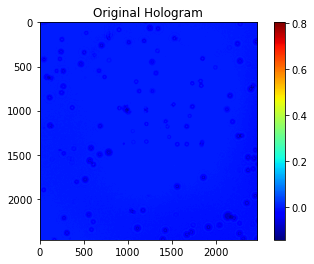

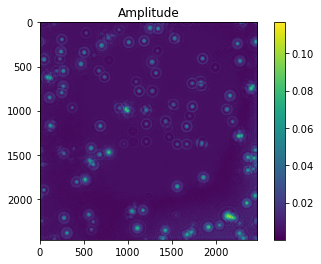

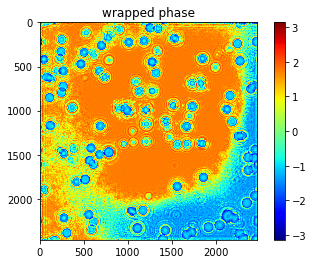

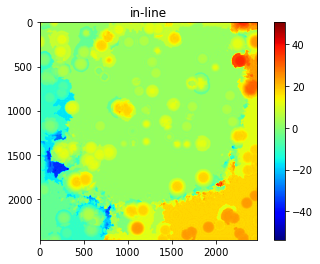

Rdist = 104.17371240257557


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.restoration import unwrap_phase
from skimage import data, img_as_float, color, exposure
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import skimage
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

# Load and read recorded hologram and reference beam into numpy
obj_str = r"C:\Users\Dave\Downloads\obj1.tif"
ref_str = r"C:\Users\Dave\Downloads\ref.tif"

holo = cv2.imread(obj_str, 0)
holo = cv2.normalize(holo.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

ref = cv2.imread(ref_str, 0)
ref = cv2.normalize(ref.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Set the coordinates of the hologram and the reference beam
Ny, Nx = holo.shape
minN = min(Ny, Nx)
print(minN)

img = holo[:minN, :minN]
ref = ref[:minN, :minN]
Ny, Nx = img.shape
# img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
# ref = cv2.normalize(ref.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Supression of the DC term using the recorded reference beam

#imgH = np.loadtxt(open(r"C:\Users\Dave\Downloads\matlab_imgH.csv", "rb"), delimiter=",", skiprows=0)

# ref_root = np.sqrt(ref)
# imgH = (img - ref) / ref_root
# imgH[imgH == np.max(imgH)] = np.median(imgH)

imgH = img - np.mean(img)

# norm_factor = np.mean(ref) / (np.mean(img)*ref)
# imgH = img * norm_factor
#imgH[imgH == np.max(imgH)] = np.median(imgH)
#imgH = cv2.normalize(imgH.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Define parameters
N = Nx
lambda_ = 488e-9
k = 2*np.pi/lambda_
dx = 1.12e-6
dy = dx
z = 8e-2
nx = np.arange(-N/2, N/2, dtype=float)
my = np.arange(-N/2, N/2, dtype=float)
w = 50e-6/2

# Determine the region of the observational plane
nF = w**2/(lambda_*z)
zz = (10*w**2)/lambda_

# Spatial coordinates x, y
x = nx*dx
y = my*dy
X, Y = np.meshgrid(x, y)

# Spectral sampling interval
dfx = 1/(N*dx)
dfy = 1/(N*dy)

# Spectral coordinates fx, fy
fx = nx*dfx
fy = my*dfy
Fx, Fy = np.meshgrid(fx, fy)

dmax = 4e-3 #

# Number of iterations
numIteration = 1
# The measured hologram amplitude is used for the an initial guess
input = imgH

# Creating initial complex-valued field distribution in the detector plane
phase = np.zeros((N, N), dtype=complex)
detField = imgH*np.exp(1j*phase)

# Creating wave propagation term
prop = np.exp((1j*2*np.pi*dmax)*np.sqrt((1/lambda_**2) - Fx**2 - Fy**2))

# Iterative loop
p = 0.01

#imgH = exposure.rescale_intensity(imgH, out_range=(0, 4 * np.pi))
for i in range(numIteration):
    print(f'Iteration:{i}')
    detField = imgH * np.exp(-1j * phase)

    # Fourier transform of the processed hologram with the DC term
    FimgH = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(detField)))
    logimg = np.log(np.abs(FimgH))
    logimgmaxmin = (logimg - np.min(np.min(logimg))) / (np.max(np.max(logimg)) - np.min(np.min(logimg)))

    # reconstruction of the transmission function, t
    t = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(FimgH * prop)))
    amp = np.abs(t)
    phi = -np.angle(t)
    phi2 = -np.arctan2(np.imag(t),np.real(t))
    absorptn = -np.log(amp)
    UnimgH = unwrap_phase(phi)
    amp = np.exp(-absorptn)
    #UnimgH = Unwrap_TIE_DCT_Iter(phi)
    #UnimgH = iterative_max_unwrap(phi, iterations=1000)
    #UnimgH = cv2.normalize(UnimgH.astype('float'), None, 0.0, 255.0, cv2.NORM_MINMAX)
    

    for ii in range(N):
        for jj in range(N):
            if absorptn[ii, jj] < 0:
                absorptn[ii, jj] = 0
                phi[ii, jj] = 0

    # displaying amplitude result
    plt.figure(20)
    plt.imshow(imgH, cmap='jet')
    #plt.axis('square')
    plt.colorbar()
    plt.title('Original Hologram')
    plt.pause(p)
    
    #amp = np.exp(-absorptn)
    plt.figure(21)
    plt.imshow(amp)
    plt.imsave('Amplitude.png', amp)
    #plt.axis('square')
    plt.colorbar()
    plt.title('Amplitude')
    plt.pause(p)

    plt.figure(22)
    plt.imshow(phi2, cmap='jet')
    plt.imsave('WrappedPhase.png', phi, cmap = 'gray')
    #plt.axis('square')
    plt.colorbar()
    plt.title('wrapped phase')
    plt.pause(p)

    plt.figure(23)
    plt.imshow(UnimgH, cmap='jet')
    plt.imsave('UnwrappedPhase.png', UnimgH, cmap = 'jet')
    #plt.axis('square')
    plt.colorbar()
    plt.title('in-line')
    plt.pause(p)
    Rdist = np.max(UnimgH) - np.min(UnimgH)
    print("Rdist = " + str(Rdist))

#     plt.figure(24)
#     plt.matshow(UnimgH2-UnimgH, cmap='jet')
#     #plt.axis('square')
#     plt.colorbar()
#     plt.title('Difference')
#     plt.pause(p)
    # updating the transmission function, t in the object plane
    t = np.zeros((N, N), dtype = 'complex')
    for ii in range(N):
        for jj in range(N):
            t[ii, jj] = complex(amp[ii, jj] * np.cos(phi[ii, jj]), amp[ii, jj] * np.sin(phi[ii, jj]))

    # calculating complex-valued wavefront in the detector plane
    iFt = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(t)))
    detField_updated = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(iFt * np.conj(prop))))
    amplitude = np.abs(detField_updated)
    phase = np.angle(detField_updated)
    true_phase = unwrap_phase(phase)


In [ ]:
# displaying amplitude result
amp = np.exp(-absorptn)
#plt.figure(20)
plt.figure(figsize = (10,10))
plt.imshow(imgH, cmap='gray')
#plt.axis('square')
plt.colorbar()
plt.title('Original Hologram')

In [32]:
np.max(imgH)

2.420099066297764

In [33]:
np.min(imgH)

-0.8379888268156425

In [ ]:
#amp = np.exp(-absorptn)
plt.figure(21)
plt.imshow(amp)
plt.imsave('Amplitude.png', amp)
#plt.axis('square')
plt.colorbar()
plt.title('Amplitude')
plt.pause(p)

In [ ]:
plt.figure(22)
plt.imshow(phi2, cmap='jet')
plt.imsave('WrappedPhase.png', phi, cmap = 'gray')
#plt.axis('square')
plt.colorbar()
plt.title('wrapped phase')
plt.pause(p)

In [ ]:
plt.figure()
plt.imshow(UnimgH, cmap='jet')
plt.imsave('UnwrappedPhase.png', UnimgH, cmap = 'jet')
#plt.axis('square')
plt.colorbar()
plt.title('in-line')
plt.pause(p)
Rdist = np.max(UnimgH) - np.min(UnimgH)
print("Rdist = " + str(Rdist))

In [26]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import AveragePooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.optimizers import Adam

In [13]:
img = cv2.convertScaleAbs(phi)
im_noise = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
im_noise = cv2.resize(im_noise, (128,128), interpolation = cv2.INTER_AREA)

In [14]:
def deep_image_prior_model():
    encoding_size = 128

    encoder = Sequential([
        Convolution2D(32, 3, padding='same', input_shape=[128,128, 3], activation='relu'),
        Convolution2D(32, 3, padding='same', activation='relu'),
        AveragePooling2D(),
        Convolution2D(64, 3, padding='same', activation='relu'),
        Convolution2D(64, 3, padding='same', activation='relu'),   
        AveragePooling2D(),
        Convolution2D(128, 3, padding='same', activation='relu'),
        Convolution2D(128, 3, padding='same', activation='relu'),
        Flatten(),
        Dense(encoding_size, activation='tanh')
    ])

    decoder = Sequential([
        Dense(192, input_shape=(encoding_size,), activation='relu'),
        Reshape((8, 8, 3)),
        Convolution2D(128, 3, padding='same', activation='relu'),
        Convolution2D(128, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(64, 3, padding='same', activation='relu'),
        Convolution2D(64, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(32, 3, padding='same', activation='relu'),
        Convolution2D(32, 3, padding='same', activation='relu'),
        UpSampling2D(),    
        Convolution2D(16, 3, padding='same', activation='relu'),
        Convolution2D(16, 3, padding='same', activation='relu'),
        UpSampling2D(),
        Convolution2D(8, 3, padding='same', activation='relu'),
        Convolution2D(3, 3, padding='same', activation='tanh')
    ])

    autoencoder = Sequential([
        encoder, 
        decoder
    ])
    
    autoencoder.compile(loss='mse', optimizer=Adam(lr=0.0001))
    return autoencoder

In [15]:
x = np.random.random(size=((1,) + im_noise.shape)) * 2 - 1
y = normalize(im_noise[None, :])
[x.shape, y.shape]

[(1, 128, 128, 3), (1, 128, 128, 3)]

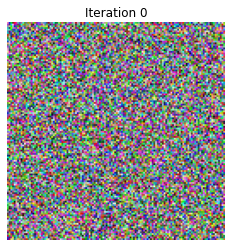

1/1 [==============================] - 0s 200ms/step


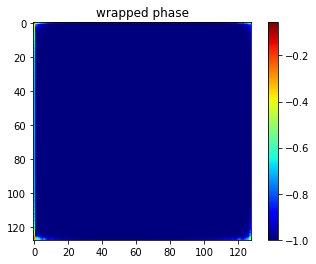

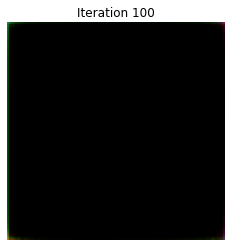

1/1 [==============================] - 0s 41ms/step


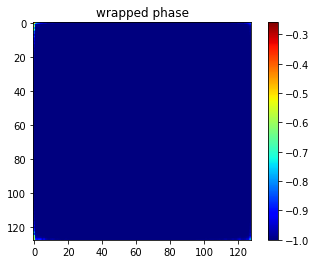

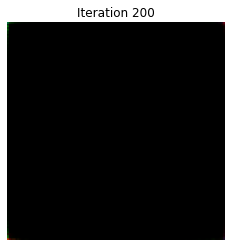

KeyboardInterrupt: 

In [20]:
plt.axis('off')
plt.title('Iteration 0')
plt.imshow(to_image(x[0]))
plt.show()

model = deep_image_prior_model()
iterations = 5                  # in hundreds
results = np.empty(x.shape)

for i in range(iterations):
    model.fit(x, y, epochs=100, batch_size=1, verbose=0)
    output = model.predict(x)
    results = np.append(results, output, axis=0)
    plt.figure(22)
    gray_img = cv2.cvtColor(output[0], cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_img, cmap='jet')
    #plt.imsave('WrappedPhase.png', phi, cmap = 'gray')
    #plt.axis('square')
    plt.colorbar()
    plt.title('wrapped phase')
    plt.pause(p)
    plt.axis('off')
    plt.title('Iteration '+ str((i+1)*100))
    plt.imshow(to_image(output[0]))
    plt.show()

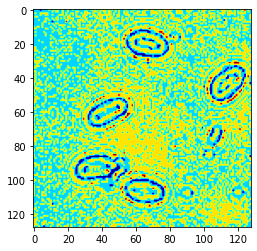

In [19]:
gray_img = cv2.cvtColor(im_noise, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='jet')